# Universidad Internacional de La Rioja  

### Máster Universitario en Visual Analytics and Big Data  

---

### **Predicción y Análisis de la Demanda y Suministro de Productos entre la Comunidad Andina y España**  
**Presentado por:** Danilo Andrés Beleño Villafañe  

---

### **Notebook 9: Modelado - Prueba XGBoost Regressor**  


In [1]:
from utils.bigquery_handler import BigQueryHandler
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

In [2]:
bqh = BigQueryHandler('unir-predictiv0-andina-espana')

query = f"""
    SELECT 
        fecha, 
        anio, 
        mes, 
        tipo_movimiento_cod, 
        cod_pais, 
        cod_provincia, 
        cod_comunidad, 
        cod_taric, 
        dolares--, 
        --kilogramos
    FROM `unir-predictiv0-andina-espana.datacomex.comex_comunidad_andina_modelo` 
    WHERE nivel_taric = '1' AND tipo_movimiento_cod = 'I' AND cod_taric = '08'
"""

data = bqh.get_bigquery_data(query)

c:\Users\USUARIO\anaconda3\Lib\site-packages\google\cloud\bigquery\table.py:1727: UserWarning: BigQuery Storage module not found, fetch data with the REST endpoint instead.
  warnings.warn(


In [4]:
data.head()

,fecha,anio,mes,tipo_movimiento_cod,cod_pais,cod_provincia,cod_comunidad,cod_taric,dolares
0,2000-04-01,2000,4,I,480,44,02,08,34025.93
1,2023-06-01,2023,6,I,516,17,08,08,108347.89
2,2002-06-01,2002,6,I,500,01,14,08,756.68
3,1996-11-01,1996,11,I,480,39,17,08,17.57
4,2005-04-01,2005,4,I,500,02,07,08,83309.61


Root Mean Squared Error (RMSE): 2648957.357215435


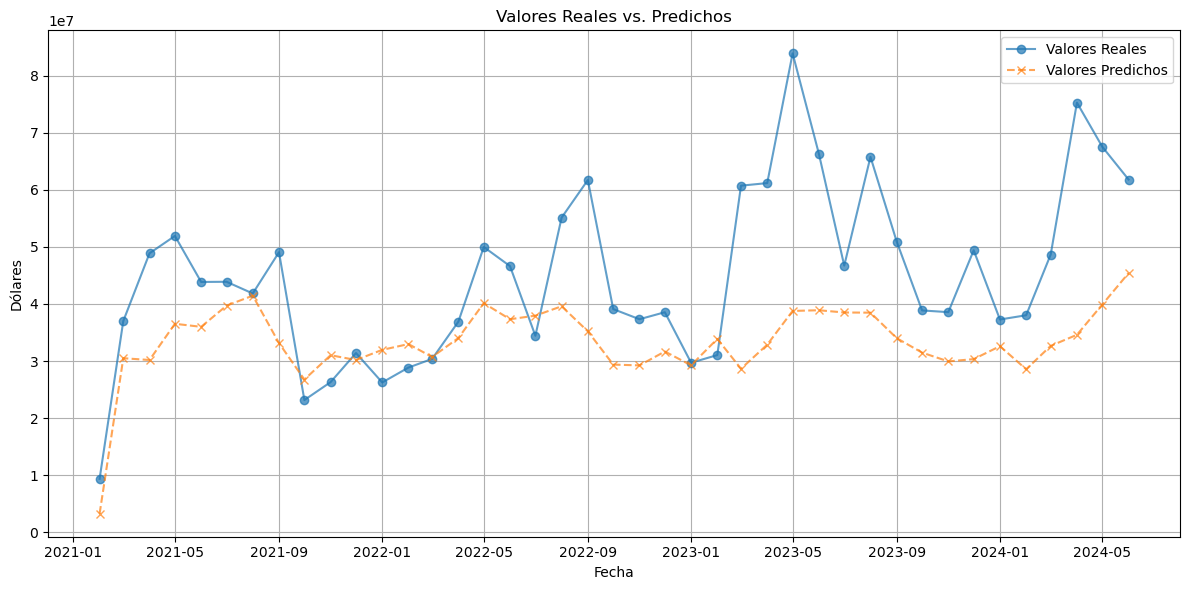

In [6]:
df = data.copy()

df = pd.DataFrame(data)


df['fecha'] = pd.to_datetime(df['fecha'])
df = df.sort_values(by='fecha').reset_index(drop=True)

df['month_sin'] = np.sin(2 * np.pi * df['mes'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['mes'] / 12)

df['dolares_lag1'] = df['dolares'].shift(1)
df['dolares_lag2'] = df['dolares'].shift(2)
df = df.dropna()



label_encoders = {}
for col in ['cod_pais', 'cod_provincia', 'cod_comunidad', 'cod_taric']:
    le = LabelEncoder()
    df[col] = le.fit_transform(df[col])
    label_encoders[col] = le

X = df[['anio', 'mes', 'cod_pais', 'cod_provincia', 'cod_comunidad', 'cod_taric']]
y = df['dolares']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

xgbr = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
xgbr.fit(X_train, y_train)

y_pred = xgbr.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print(f"Root Mean Squared Error (RMSE): {rmse}")


#results = pd.DataFrame({
#    'fecha': df.iloc[X_test.index]['fecha'].values,
#    'dolares_real': y_test.values,
#    'dolares_pred': y_pred
#}).reset_index(drop=True)

results = pd.DataFrame({
    'fecha': df.loc[X_test.index, 'fecha'], 
    'dolares_real': y_test.values,   
    'dolares_pred': y_pred         
}).reset_index(drop=True)




results['fecha'] = pd.to_datetime(results['fecha'])

results_grouped = results.groupby('fecha').sum().reset_index()
results_grouped = results_grouped[results_grouped["fecha"] > pd.to_datetime("2010-12-31")]

#results_grouped['dolares_real'] /= 1e6
#results_grouped['dolares_pred'] /= 1e6

plt.figure(figsize=(12, 6))
plt.plot(results_grouped['fecha'], results_grouped['dolares_real'], label='Valores Reales', marker='o', linestyle='-', alpha=0.7)
plt.plot(results_grouped['fecha'], results_grouped['dolares_pred'], label='Valores Predichos', marker='x', linestyle='--', alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Dólares')
plt.title('Valores Reales vs. Predichos')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

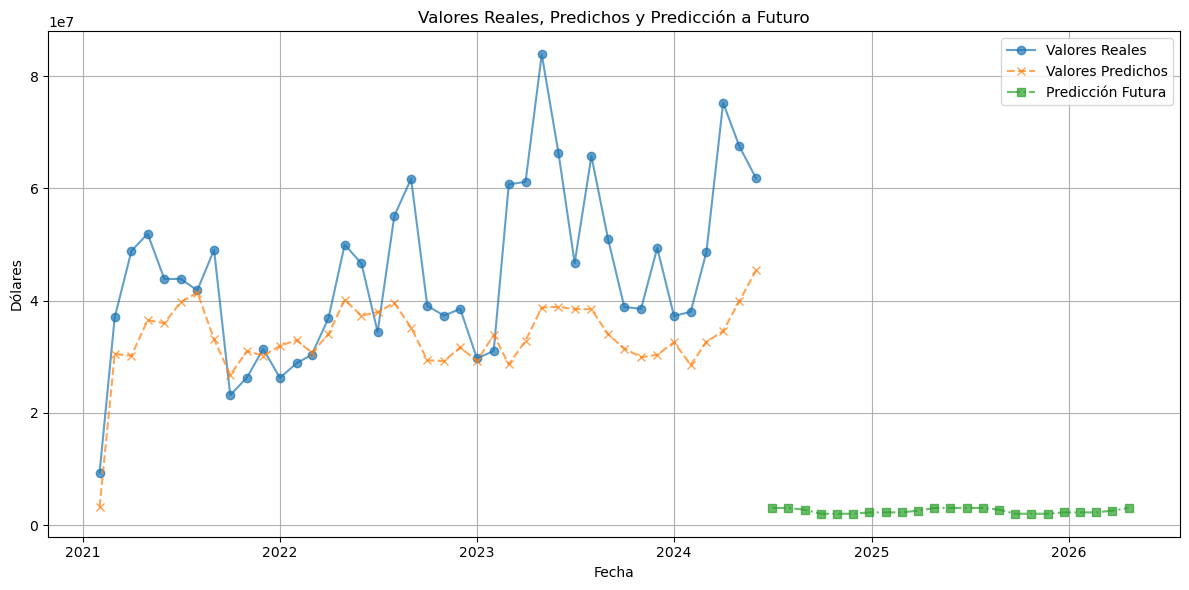

In [8]:
from datetime import datetime, timedelta

ultima_fecha = df['fecha'].max()
anio, mes = ultima_fecha.year, ultima_fecha.month

meses_futuros = []
for i in range(1, 24):
    mes += 1
    if mes > 12:
        mes = 1
        anio += 1
    meses_futuros.append({'anio': anio, 'mes': mes})

prediccion_futura = pd.DataFrame(meses_futuros)

valores_comunes = df[['cod_pais', 'cod_provincia', 'cod_comunidad', 'cod_taric']].mode().iloc[0]
for col in ['cod_pais', 'cod_provincia', 'cod_comunidad', 'cod_taric']:
    prediccion_futura[col] = valores_comunes[col]

X_futuro = prediccion_futura[['anio', 'mes', 'cod_pais', 'cod_provincia', 'cod_comunidad', 'cod_taric']]
#X_futuro['month_sin'] = np.sin(2 * np.pi * X_futuro['mes'] / 12)
#X_futuro['month_cos'] = np.cos(2 * np.pi * X_futuro['mes'] / 12)

y_futuro_pred = xgbr.predict(X_futuro)

prediccion_futura['fecha'] = [
    ultima_fecha + timedelta(days=30 * i) for i in range(1, len(prediccion_futura) + 1)
]
prediccion_futura['dolares_pred'] = y_futuro_pred

results_grouped_futuro = prediccion_futura[['fecha', 'dolares_pred']]
results_grouped_futuro = results_grouped_futuro.rename(columns={'dolares_pred': 'dolares_pred_future'})

plt.figure(figsize=(12, 6))
plt.plot(results_grouped['fecha'], results_grouped['dolares_real'], label='Valores Reales', marker='o', linestyle='-', alpha=0.7)
plt.plot(results_grouped['fecha'], results_grouped['dolares_pred'], label='Valores Predichos', marker='x', linestyle='--', alpha=0.7)
plt.plot(results_grouped_futuro['fecha'], results_grouped_futuro['dolares_pred_future'], label='Predicción Futura', marker='s', linestyle='-.', alpha=0.7)
plt.xlabel('Fecha')
plt.ylabel('Dólares')
plt.title('Valores Reales, Predichos y Predicción a Futuro')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
